1. Import YFinance + G9 Excel 2020
3. Compute ROE & DuPont metrics
6. Plot charts
7. Conclusion


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def get_yf_financials(ticker):
  t = yf.Ticker(ticker)

  IS = t.financials
  BS = t.balance_sheet

  equity_key = None
  if "Total Stockholder Equity" in BS.index:
    equity_key = "Total Stockholder Equity"
  elif "Stockholders Equity" in BS.index:
    equity_key = "Stockholders Equity"
  else:
    raise KeyError(f"Could not find a valid equity key for {ticker} in Balance Sheet Index. Available keys: {BS.index.tolist()}")

  # Create DataFrame with financial metrics as columns and dates as index
  df = pd.DataFrame ({
      "Sales": IS.loc["Total Revenue"],
      "NetIncome" : IS.loc["Net Income"],
      "Assets": BS.loc["Total Assets"],
      "Equity": BS.loc[equity_key]
  })

  # Transpose the DataFrame so years become columns and metrics become rows
  df = df.T

  # Extract year from the DatetimeIndex columns and assign them as new column names
  df.columns = df.columns.year

  # Sort the columns (years) chronologically
  df = df.sort_index(axis=1)
  return df

csv_2020 = pd.read_csv("/content/Book2.csv", sep=',')
override = csv_2020.set_index(["Company","Year"])

#example acces
override
#att_2020 = override["AT&T"]
#vz_2020 = override["VZ"]


,,Sales,Net Income,Assets,Equity
Company,Year,,,,
AT&T,2020,143050,-5176,525761,179240
Verizon,2020,128292,18348,316481,69272


In [ ]:
#step 3 Combine Yfinance + CSV Override i.e 2020 data

def apply_2020_override(df_yf, df_override, company):
    """
    df_yf: YFinance dataframe for the ticker (2021–2024)
    df_override: CSV override table for the year 2020
    company: "AT&T" or "Verizon"
    """
    df = df_yf.copy()

    ov = df_override.loc[(company, 2020)]

    df[2020] = [ov["Sales"], ov["NetIncome"], ov["Assets"], ov["Equity"]]

    #reorder chronologically

    df= df.reindex(sorted(df.columns), axis= 1)

    return df




In [ ]:
att_yf = get_yf_financials("T")
vz_yf = get_yf_financials("VZ")



# 2) Apply 2020 override
ov = override

def build_5y(df_yf, company):
    # Start from YF data
    df = df_yf.copy()

    # Add/overwrite 2020 from CSV
    o = ov.loc[(company, 2020)]
    df.loc["Sales", 2020]     = o["Sales"]
    df.loc["NetIncome", 2020] = o["Net Income"]
    df.loc["Assets", 2020]    = o["Assets"]
    df.loc["Equity", 2020]    = o["Equity"]

    # Now force exactly 2020–2024 in order
    years = [2020, 2021, 2022, 2023, 2024]
    df = df.reindex(columns=years)

    return df

att_raw = build_5y(att_yf, "AT&T")
vz_raw  = build_5y(vz_yf, "Verizon")

print(att_raw.columns)  # should be Int64Index([2020, 2021, 2022, 2023, 2024])
print(vz_raw.columns)



Index([2020, 2021, 2022, 2023, 2024], dtype='int64')
Index([2020, 2021, 2022, 2023, 2024], dtype='int64')


In [ ]:
# ROE = Net Income / Equity
att_raw.loc["ROE"] = att_raw.loc["NetIncome"] / att_raw.loc["Equity"]
vz_raw.loc["ROE"]  = vz_raw.loc["NetIncome"]  / vz_raw.loc["Equity"]

att_raw.loc["ROE"], vz_raw.loc["ROE"]


(2020   -0.028877
 2021    0.120728
 2022   -0.087426
 2023    0.139404
 2024    0.104894
 Name: ROE, dtype: float64,
 2020    0.264869
 2021    0.269776
 2022    0.233213
 2023    0.125652
 2024    0.176406
 Name: ROE, dtype: float64)

In [ ]:
def dupont(df):
    dup = pd.DataFrame(index=["ProfitMargin","AssetTurnover","EquityMultiplier","ROE","DuPontROE"],
                       columns=df.columns)

    # Components
    dup.loc["ProfitMargin"] = df.loc["NetIncome"] / df.loc["Sales"]
    dup.loc["AssetTurnover"] = df.loc["Sales"] / df.loc["Assets"]
    dup.loc["EquityMultiplier"] = df.loc["Assets"] / df.loc["Equity"]

    # ROE (same as your earlier calc, but recomputed cleanly)
    dup.loc["ROE"] = df.loc["NetIncome"] / df.loc["Equity"]

    # Reconstructed ROE
    dup.loc["DuPontROE"] = (
        dup.loc["ProfitMargin"] *
        dup.loc["AssetTurnover"] *
        dup.loc["EquityMultiplier"]
    )

    return dup


In [ ]:
att_dup = dupont(att_raw)
vz_dup  = dupont(vz_raw)

att_dup, vz_dup

(                      2020      2021      2022      2023      2024
 ProfitMargin     -0.036183  0.149816 -0.070597   0.11762  0.089491
 AssetTurnover     0.272082  0.242989  0.299715  0.300762  0.309872
 EquityMultiplier  2.933279  3.316391  4.131826  3.940676  3.782576
 ROE              -0.028877  0.120728 -0.087426  0.139404  0.104894
 DuPontROE        -0.028877  0.120728 -0.087426  0.139404  0.104894,
                       2020      2021      2022      2023      2024
 ProfitMargin      0.143017  0.165141   0.15534  0.086688  0.129878
 AssetTurnover      0.40537  0.364469  0.360396  0.352327  0.350362
 EquityMultiplier  4.568671  4.482162  4.165716  4.113978  3.876689
 ROE               0.264869  0.269776  0.233213  0.125652  0.176406
 DuPontROE         0.264869  0.269776  0.233213  0.125652  0.176406)

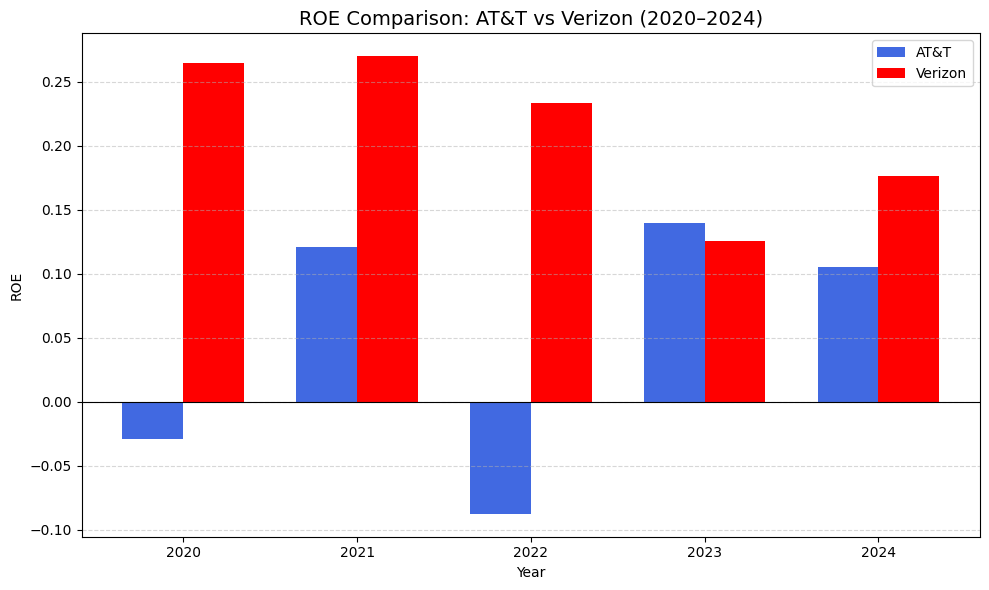

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract years and ROE values
years = att_dup.columns.astype(int)
att_roe = att_dup.loc["ROE"].values
vz_roe = vz_dup.loc["ROE"].values

# Bar width and positions
x = np.arange(len(years))
width = 0.35

plt.figure(figsize=(10,6))

# Plot bars with custom colors
plt.bar(x - width/2, att_roe, width, label="AT&T", color="royalblue")
plt.bar(x + width/2, vz_roe, width, label="Verizon", color="red")

plt.title("ROE Comparison: AT&T vs Verizon (2020–2024)", fontsize=14)
plt.xlabel("Year")
plt.ylabel("ROE")
plt.xticks(x, years)
plt.axhline(0, color='black', linewidth=0.8)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.legend()
plt.tight_layout()
plt.show()


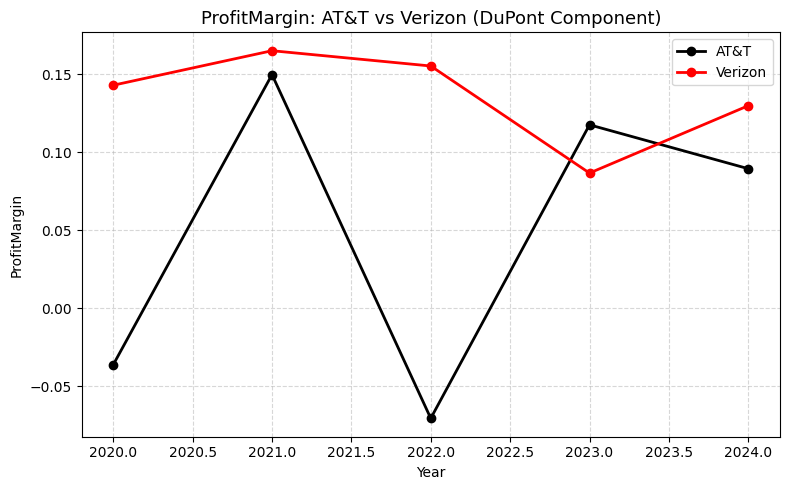

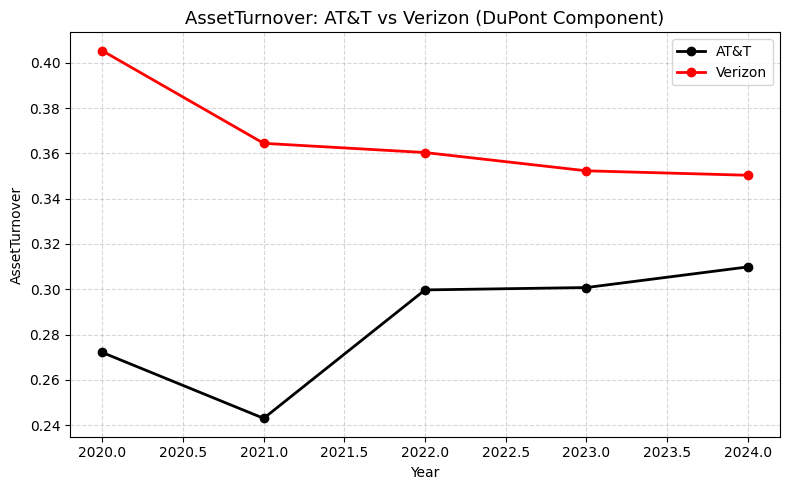

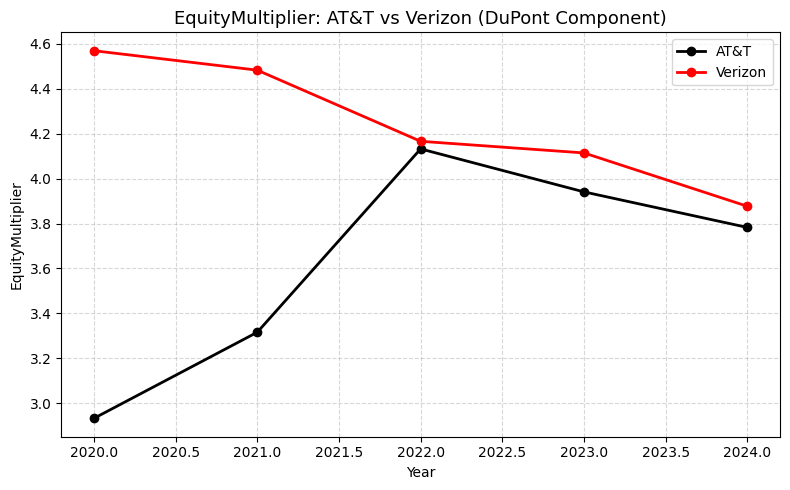

In [ ]:
import matplotlib.pyplot as plt

years = att_dup.columns
components = ["ProfitMargin", "AssetTurnover", "EquityMultiplier"]

for c in components:
    plt.figure(figsize=(8,5))

    # AT&T = black
    plt.plot(years, att_dup.loc[c], marker="o", color="black", linewidth=2, label="AT&T")

    # Verizon = red
    plt.plot(years, vz_dup.loc[c], marker="o", color="red", linewidth=2, label="Verizon")

    plt.title(f"{c}: AT&T vs Verizon (DuPont Component)", fontsize=13)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.xlabel("Year")
    plt.ylabel(c)
    plt.legend()
    plt.tight_layout()
    plt.show()


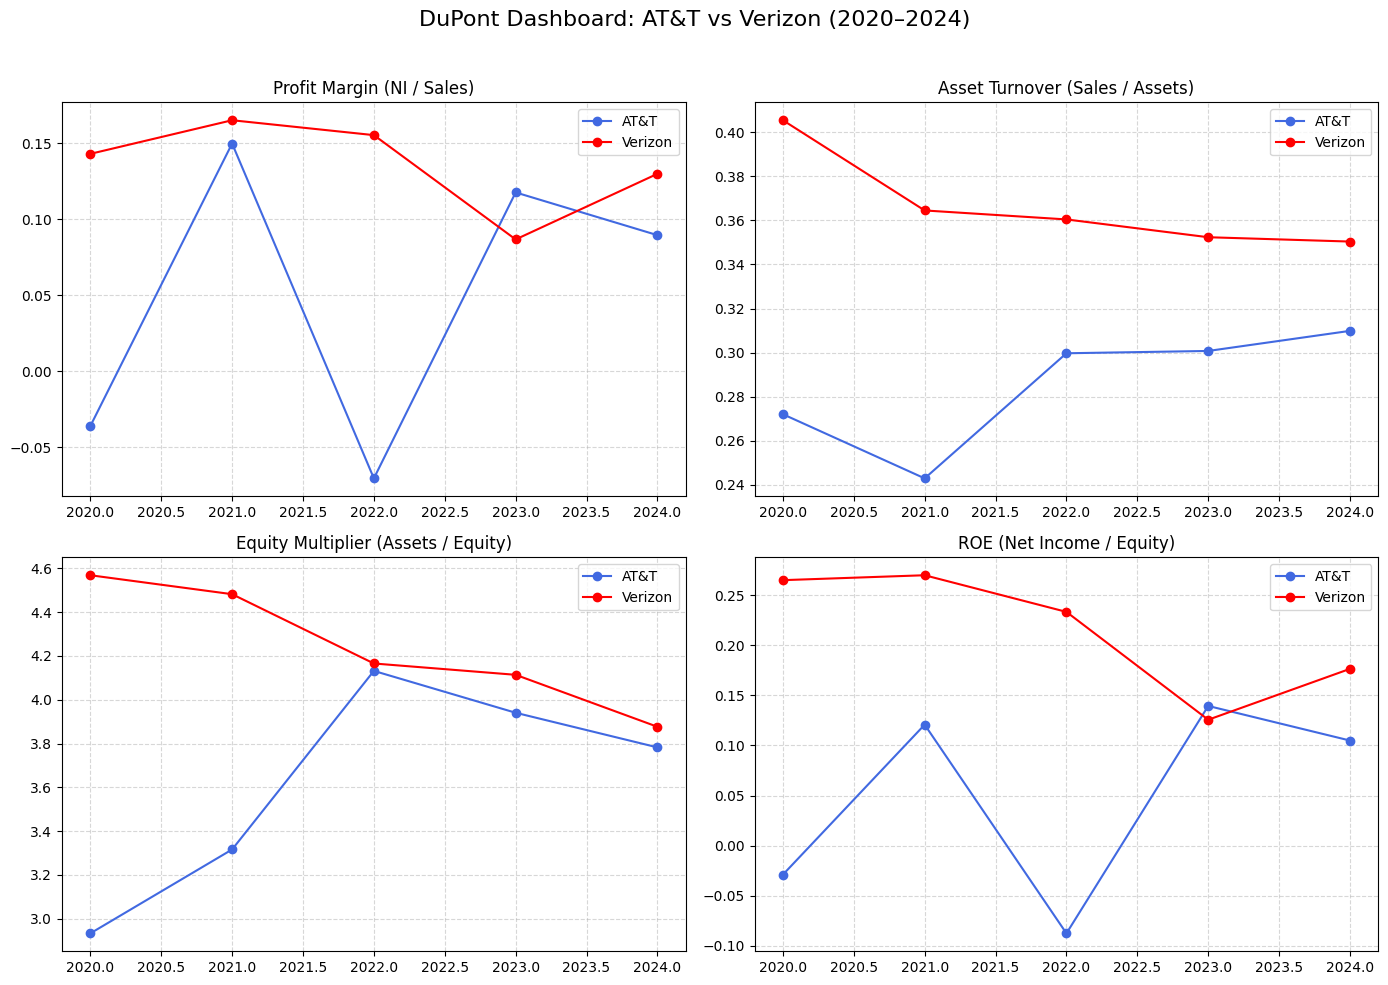

In [ ]:
import matplotlib.pyplot as plt

years = att_dup.columns.astype(int)

fig, axes = plt.subplots(2, 2, figsize=(14,10))
fig.suptitle("DuPont Dashboard: AT&T vs Verizon (2020–2024)", fontsize=16)

# 1. Profit Margin
axes[0,0].plot(years, att_dup.loc["ProfitMargin"], marker='o', color="royalblue", label="AT&T")
axes[0,0].plot(years, vz_dup.loc["ProfitMargin"], marker='o', color="red",   label="Verizon")
axes[0,0].set_title("Profit Margin (NI / Sales)")
axes[0,0].grid(True, linestyle="--", alpha=0.5)
axes[0,0].legend()

# 2. Asset Turnover
axes[0,1].plot(years, att_dup.loc["AssetTurnover"], marker='o', color="royalblue", label="AT&T")
axes[0,1].plot(years, vz_dup.loc["AssetTurnover"], marker='o', color="red",   label="Verizon")
axes[0,1].set_title("Asset Turnover (Sales / Assets)")
axes[0,1].grid(True, linestyle="--", alpha=0.5)
axes[0,1].legend()

# 3. Equity Multiplier
axes[1,0].plot(years, att_dup.loc["EquityMultiplier"], marker='o', color="royalblue", label="AT&T")
axes[1,0].plot(years, vz_dup.loc["EquityMultiplier"], marker='o', color="red",   label="Verizon")
axes[1,0].set_title("Equity Multiplier (Assets / Equity)")
axes[1,0].grid(True, linestyle="--", alpha=0.5)
axes[1,0].legend()

# 4. ROE
axes[1,1].plot(years, att_dup.loc["ROE"], marker='o', color="royalblue", label="AT&T")
axes[1,1].plot(years, vz_dup.loc["ROE"], marker='o', color="red",   label="Verizon")
axes[1,1].set_title("ROE (Net Income / Equity)")
axes[1,1].grid(True, linestyle="--", alpha=0.5)
axes[1,1].legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



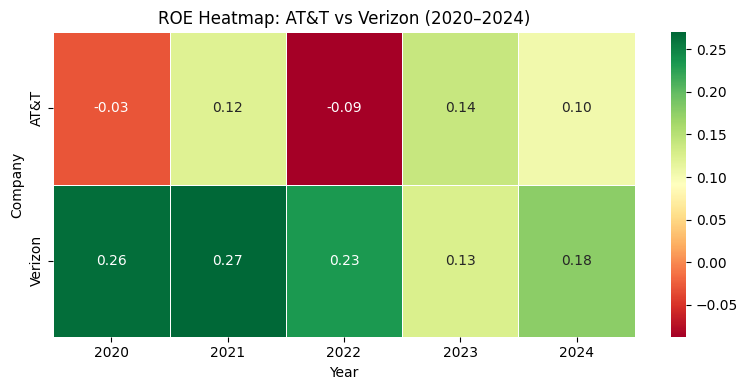

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Build ROE matrix
roe_matrix = pd.DataFrame({
    "AT&T": att_dup.loc["ROE"].astype(float),
    "Verizon": vz_dup.loc["ROE"].astype(float)
}).T  # transpose so companies are rows

plt.figure(figsize=(8,4))
sns.heatmap(
    roe_matrix,
    annot=True,
    fmt=".2f",
    cmap="RdYlGn",
    linewidths=.5,
    cbar=True
)

plt.title("ROE Heatmap: AT&T vs Verizon (2020–2024)")
plt.xlabel("Year")
plt.ylabel("Company")
plt.tight_layout()
plt.show()

In [ ]:
def dupont_drivers(dup):
    """
    dup = DuPont table from dupont(att_raw) or dupont(vz_raw)
    Returns a DataFrame of changes in PM, AT, EM, and ROE.
    """
    years = dup.columns
    drivers = pd.DataFrame(index=["ProfitMargin", "AssetTurnover", "EquityMultiplier", "ROE"],
                           columns=years[1:])  # changes start in year 2

    for i in range(1, len(years)):
        prev = years[i-1]
        curr = years[i]

        drivers.loc["ProfitMargin", curr] = dup.loc["ProfitMargin", curr] - dup.loc["ProfitMargin", prev]
        drivers.loc["AssetTurnover", curr] = dup.loc["AssetTurnover", curr] - dup.loc["AssetTurnover", prev]
        drivers.loc["EquityMultiplier", curr] = dup.loc["EquityMultiplier", curr] - dup.loc["EquityMultiplier", prev]
        drivers.loc["ROE", curr] = dup.loc["ROE", curr] - dup.loc["ROE", prev]

    return drivers


In [ ]:
att_drivers = dupont_drivers(att_dup)
vz_drivers  = dupont_drivers(vz_dup)

att_drivers, vz_drivers


(                      2021      2022      2023      2024
 ProfitMargin      0.185999 -0.220413  0.188218 -0.028129
 AssetTurnover    -0.029093  0.056726  0.001047  0.009111
 EquityMultiplier  0.383112  0.815434  -0.19115   -0.1581
 ROE               0.149606 -0.208154  0.226829  -0.03451,
                       2021      2022      2023      2024
 ProfitMargin      0.022124 -0.009801 -0.068652   0.04319
 AssetTurnover    -0.040901 -0.004074 -0.008069 -0.001965
 EquityMultiplier  -0.08651 -0.316446 -0.051738 -0.237289
 ROE               0.004907 -0.036563 -0.107562  0.050754)

In [ ]:
import matplotlib.pyplot as plt

def plot_waterfall(drivers, company):
    years = drivers.columns.astype(int)
    components = ["ProfitMargin", "AssetTurnover", "EquityMultiplier"]
    labels = ["Profit Margin", "Asset Turnover", "Equity Multiplier"]

    for year in years:
        plt.figure(figsize=(10,6))

        changes = [
            drivers.loc["ProfitMargin", year],
            drivers.loc["AssetTurnover", year],
            drivers.loc["EquityMultiplier", year],
        ]

        colors = ["orange", "steelblue", "green"]

        plt.bar(labels, changes, color=colors)

        # zero line
        plt.axhline(0, color="black", linewidth=0.8)

        plt.title(f"ROE Change Drivers: {company} ({year-1} → {year})", fontsize=14)
        plt.ylabel("Δ Contribution to ROE")
        plt.grid(axis="y", linestyle="--", alpha=0.5)
        plt.tight_layout()
        plt.show()


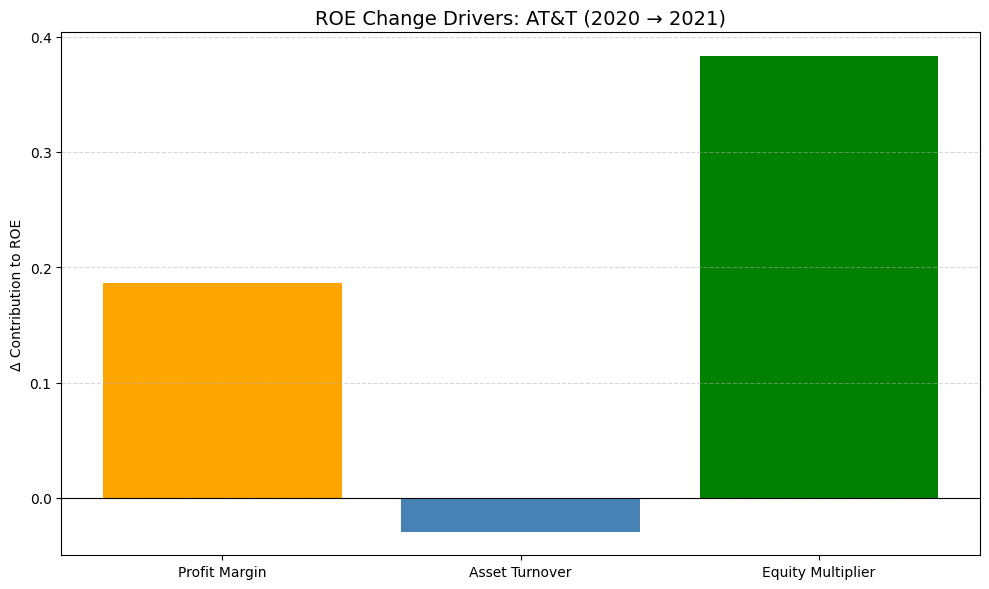

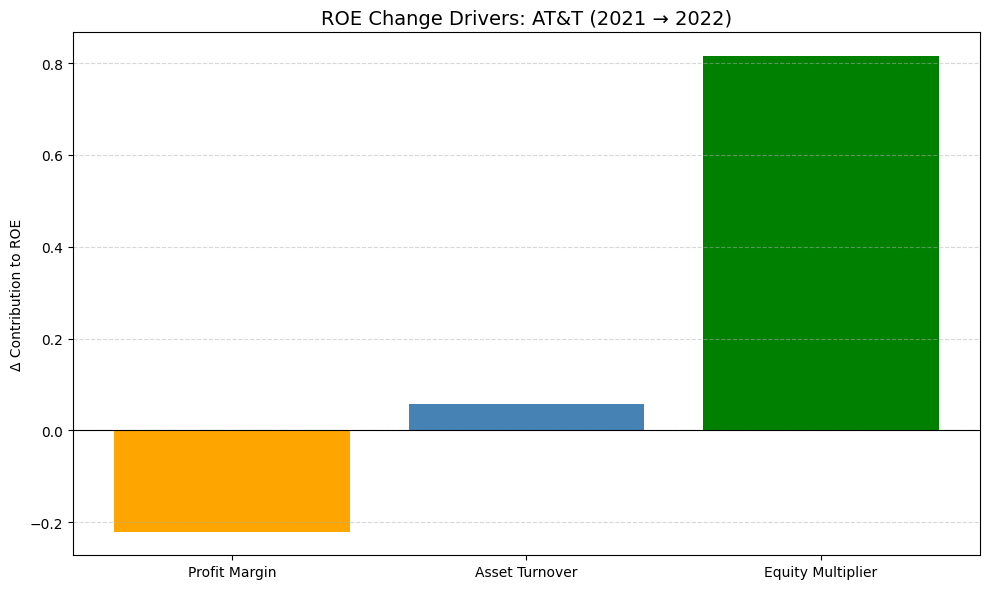

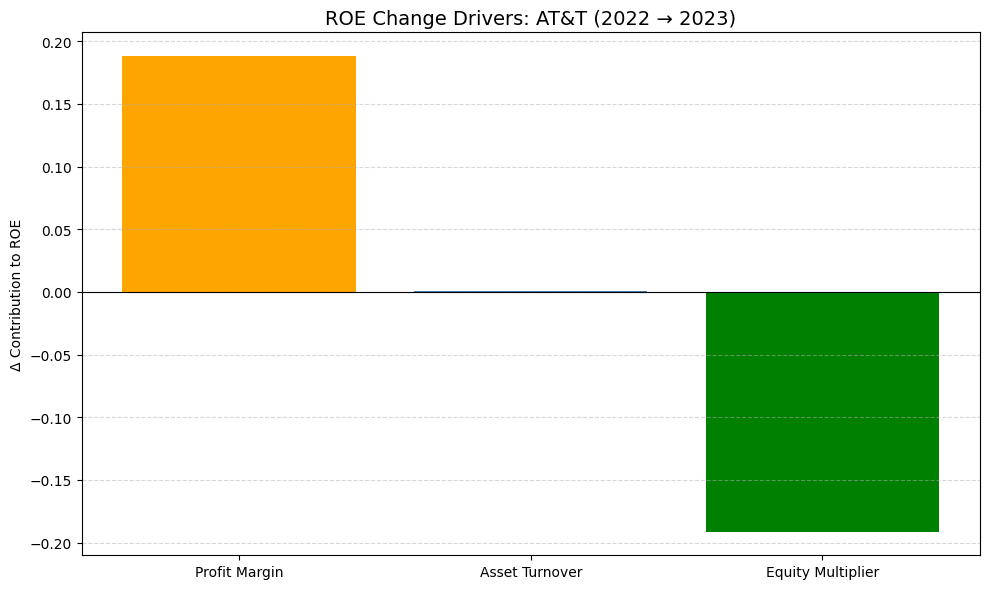

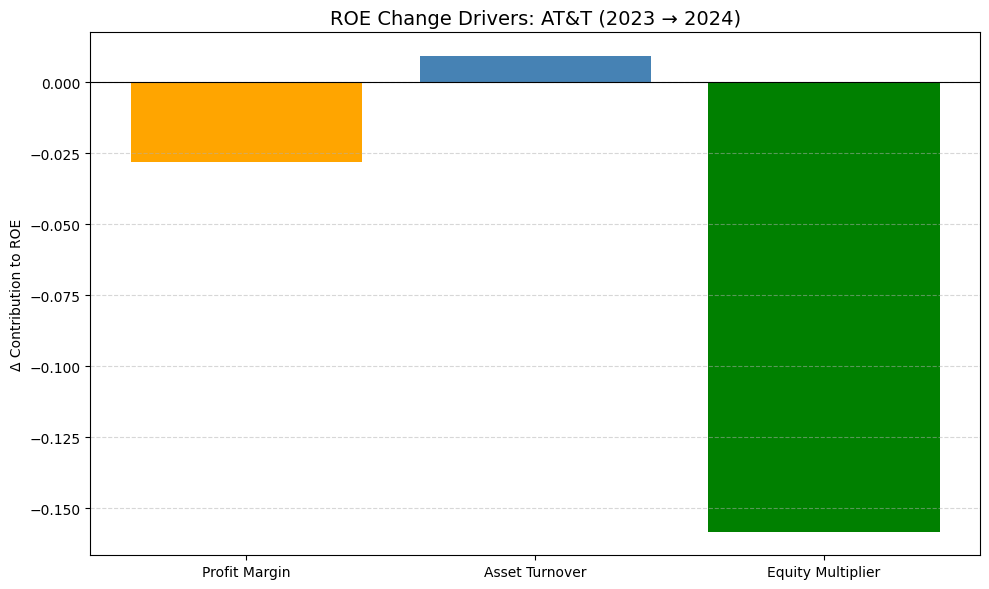

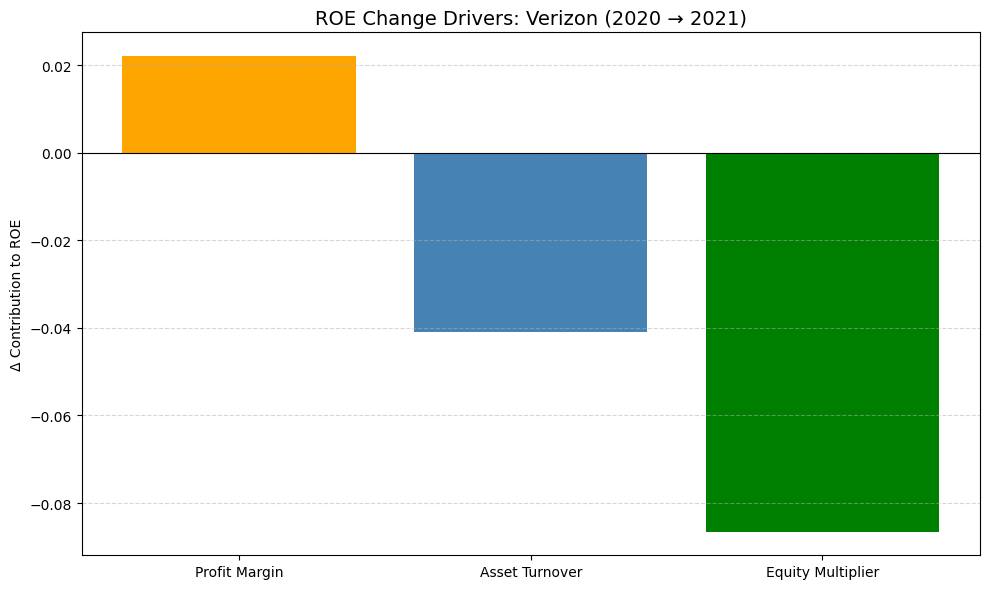

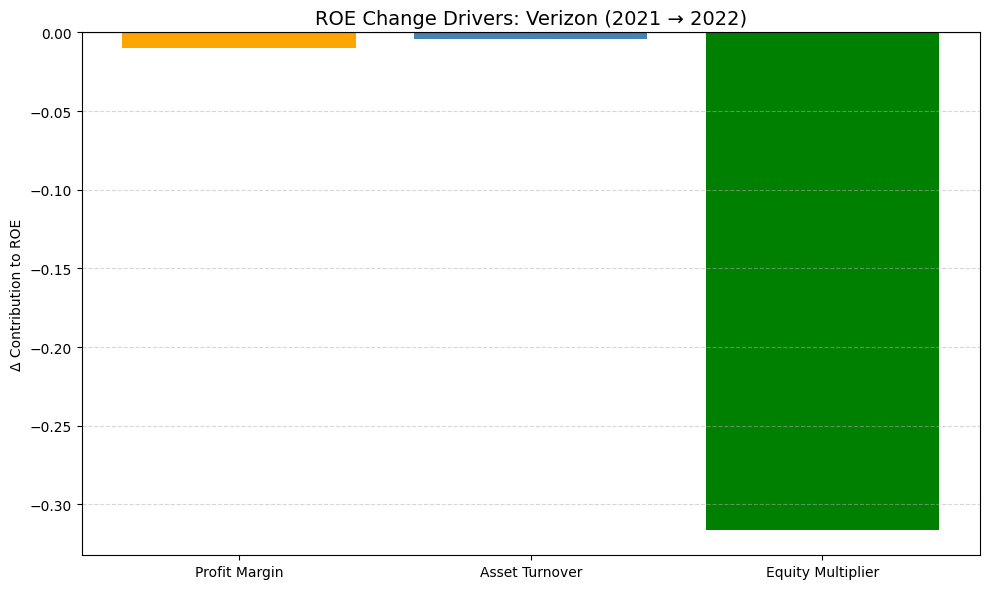

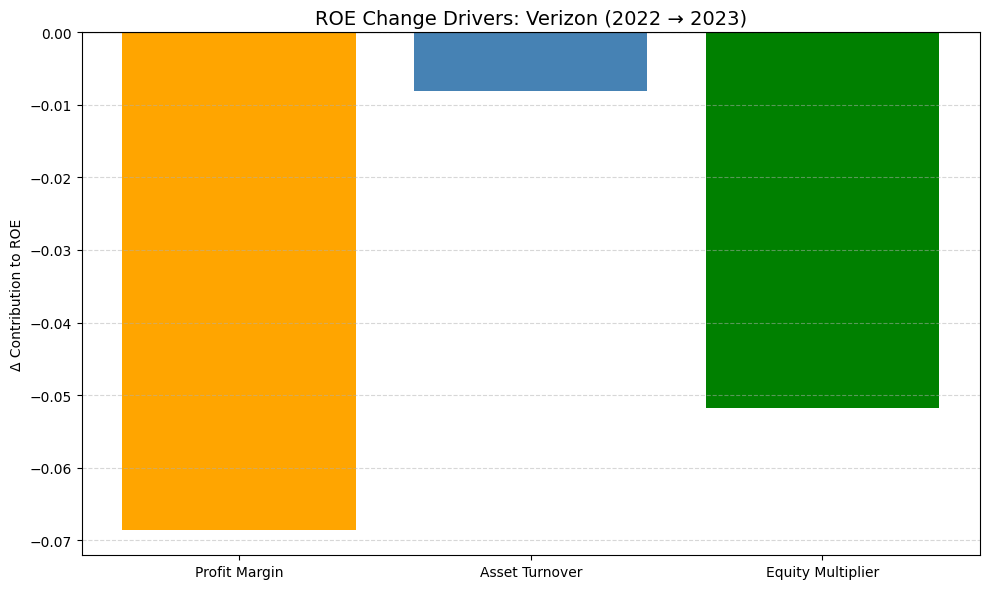

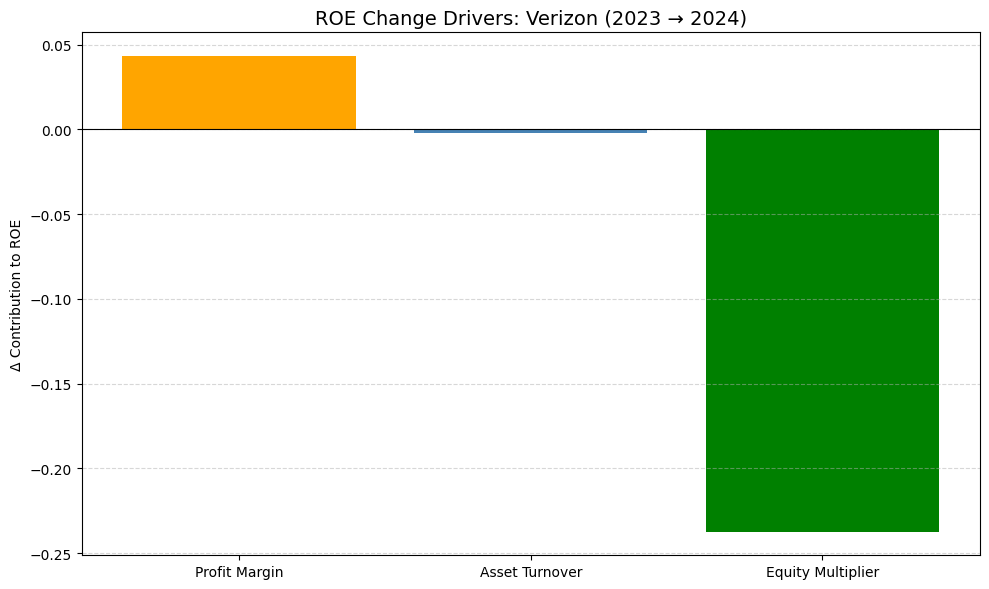

In [ ]:
plot_waterfall(att_drivers, "AT&T")
plot_waterfall(vz_drivers, "Verizon")

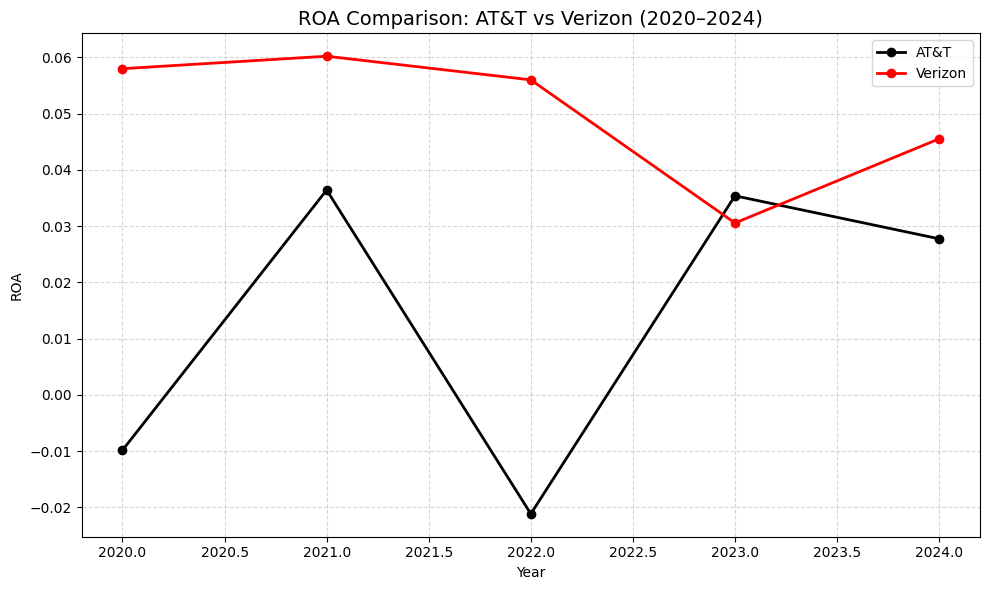

In [ ]:
import matplotlib.pyplot as plt

# Calculate ROA
att_raw.loc["ROA"] = att_raw.loc["NetIncome"] / att_raw.loc["Assets"]
vz_raw.loc["ROA"]  = vz_raw.loc["NetIncome"]  / vz_raw.loc["Assets"]

years = att_raw.columns.astype(int)

plt.figure(figsize=(10,6))

plt.plot(years,
         att_raw.loc["ROA"],
         marker="o",
         linewidth=2,
         label="AT&T",
         color="black") # Changed color to black

plt.plot(years,
         vz_raw.loc["ROA"],
         marker="o",
         linewidth=2,
         label="Verizon",
         color="red") # Changed color to red

plt.title("ROA Comparison: AT&T vs Verizon (2020–2024)", fontsize=14)
plt.xlabel("Year")
plt.ylabel("ROA")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


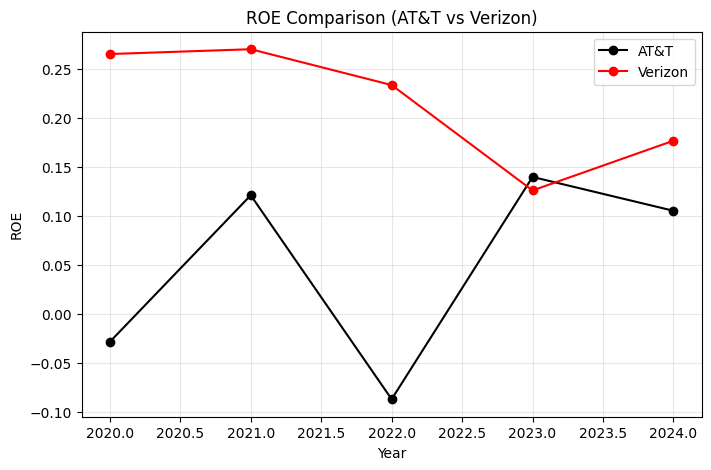

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(att_raw.columns, att_raw.loc["ROE"], marker='o', color='black', label='AT&T')
plt.plot(vz_raw.columns,  vz_raw.loc["ROE"], marker='o', color='red', label='Verizon')

plt.title("ROE Comparison (AT&T vs Verizon)")
plt.xlabel("Year")
plt.ylabel("ROE")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

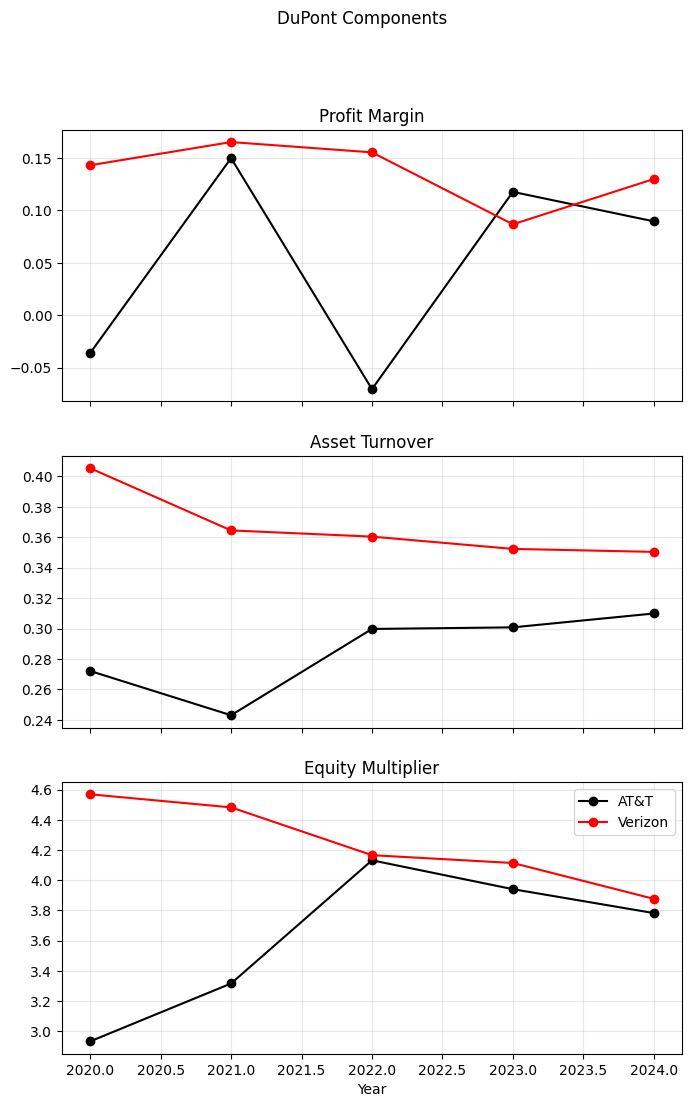

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(8,12), sharex=True)

metrics = ["ProfitMargin", "AssetTurnover", "EquityMultiplier"]
titles  = ["Profit Margin", "Asset Turnover", "Equity Multiplier"]

for i, metric in enumerate(metrics):
    ax[i].plot(att_dup.columns, att_dup.loc[metric], color='black', marker='o', label='AT&T')
    ax[i].plot(vz_dup.columns,  vz_dup.loc[metric], color='red', marker='o', label='Verizon')
    ax[i].set_title(titles[i])
    ax[i].grid(alpha=0.3)

plt.xlabel("Year")
plt.suptitle("DuPont Components")
plt.legend()
plt.show()


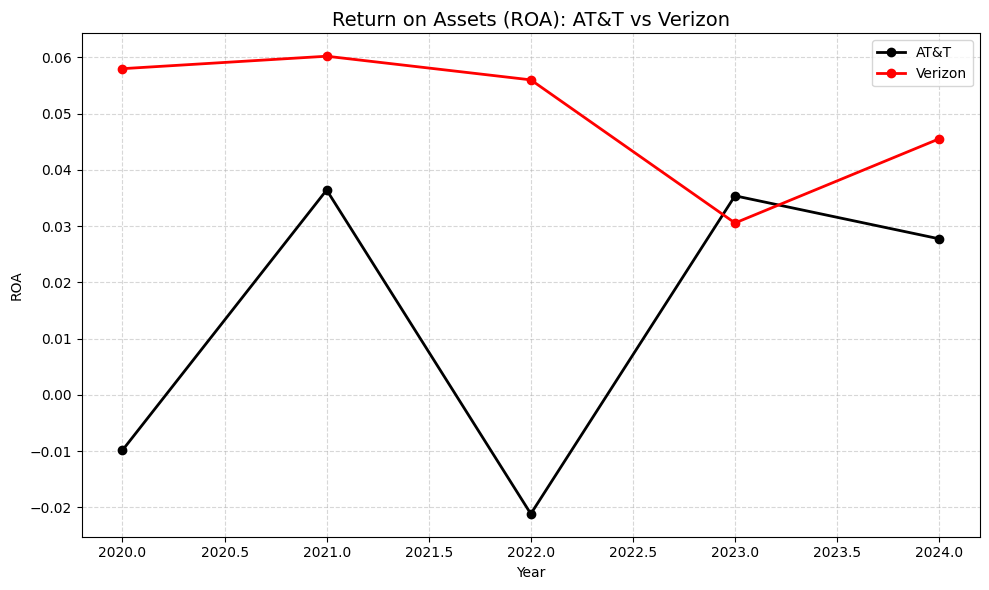

In [ ]:
plt.figure(figsize=(10,6))

years = att_raw.columns.astype(int)

plt.plot(years, att_raw.loc["ROA"], marker="o", color="black", linewidth=2, label="AT&T")
plt.plot(years, vz_raw.loc["ROA"],  marker="o", color="red",   linewidth=2, label="Verizon")

plt.title("Return on Assets (ROA): AT&T vs Verizon", fontsize=14)
plt.xlabel("Year")
plt.ylabel("ROA")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


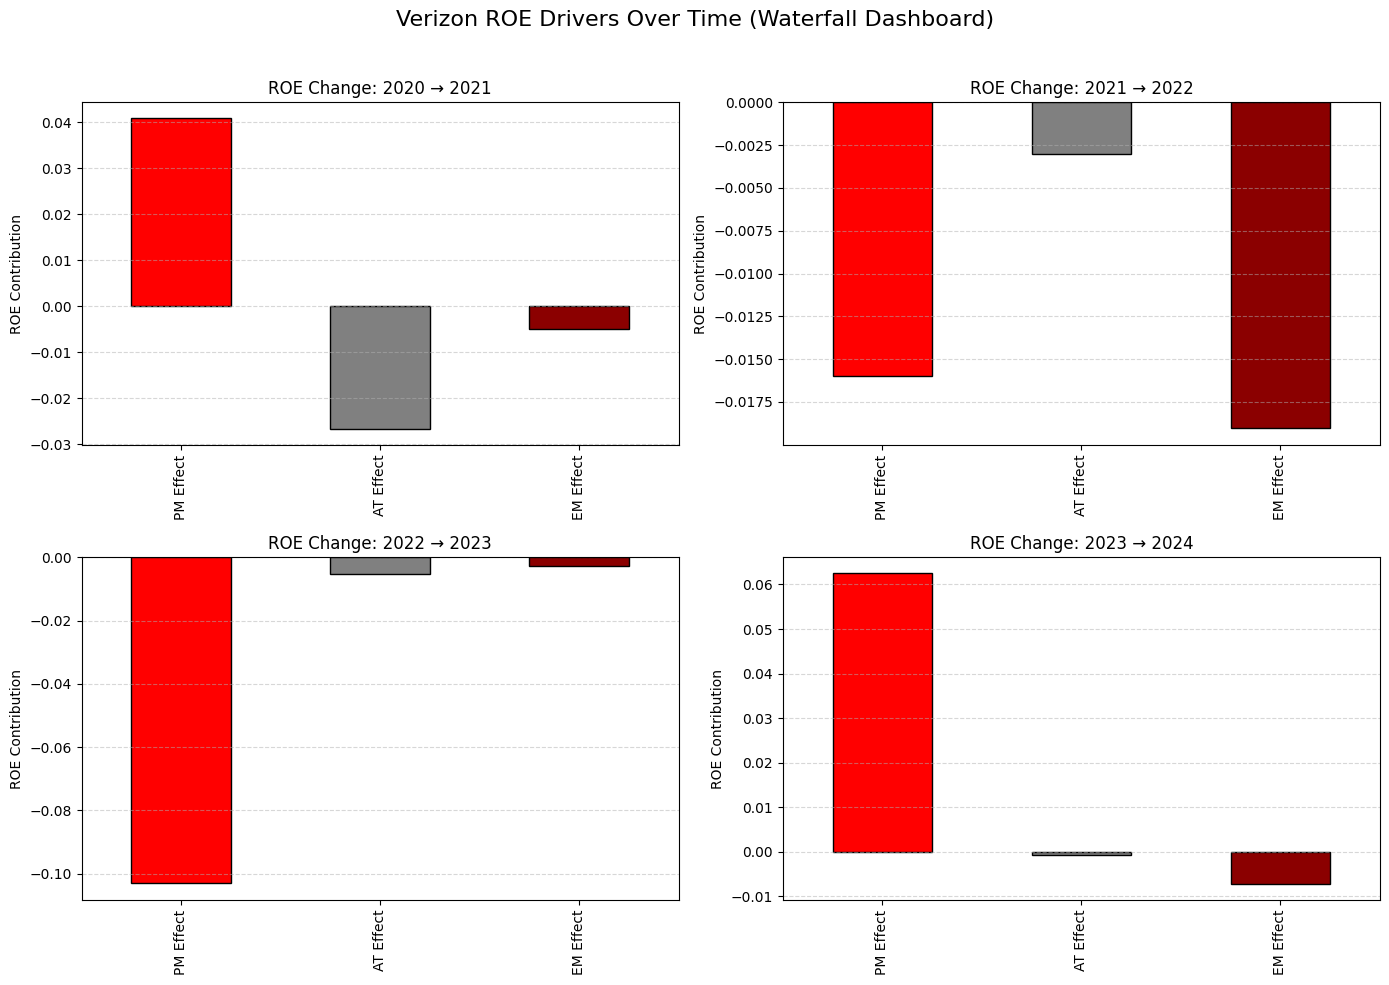

In [ ]:


# Function to compute PM, AT, EM effects
def roe_waterfall(prev_year, curr_year, dup):
    # Use the full index names as defined in the dupont function
    pm_prev, at_prev, em_prev = dup.loc["ProfitMargin", prev_year], dup.loc["AssetTurnover", prev_year], dup.loc["EquityMultiplier", prev_year]
    pm_curr, at_curr, em_curr = dup.loc["ProfitMargin", curr_year], dup.loc["AssetTurnover", curr_year], dup.loc["EquityMultiplier", curr_year]

    effect_pm = (pm_curr - pm_prev) * at_prev * em_prev
    effect_at = pm_prev * (at_curr - at_prev) * em_prev
    effect_em = pm_prev * at_prev * (em_curr - em_prev)

    return pd.Series({"PM Effect": effect_pm, "AT Effect": effect_at, "EM Effect": effect_em})


# Build dashboard
year_pairs = [(2020,2021),(2021,2022),(2022,2023),(2023,2024)]

fig, axes = plt.subplots(2, 2, figsize=(14,10))
fig.suptitle("Verizon ROE Drivers Over Time (Waterfall Dashboard)", fontsize=16)

for ax, (y1,y2) in zip(axes.flatten(), year_pairs):
    wf = roe_waterfall(y1, y2, vz_dup)

    wf.plot(kind="bar",
            ax=ax,
            color=["red", "gray", "darkred"],
            edgecolor="black")

    ax.set_title(f"ROE Change: {y1} → {y2}", fontsize=12)
    ax.set_ylabel("ROE Contribution")
    ax.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


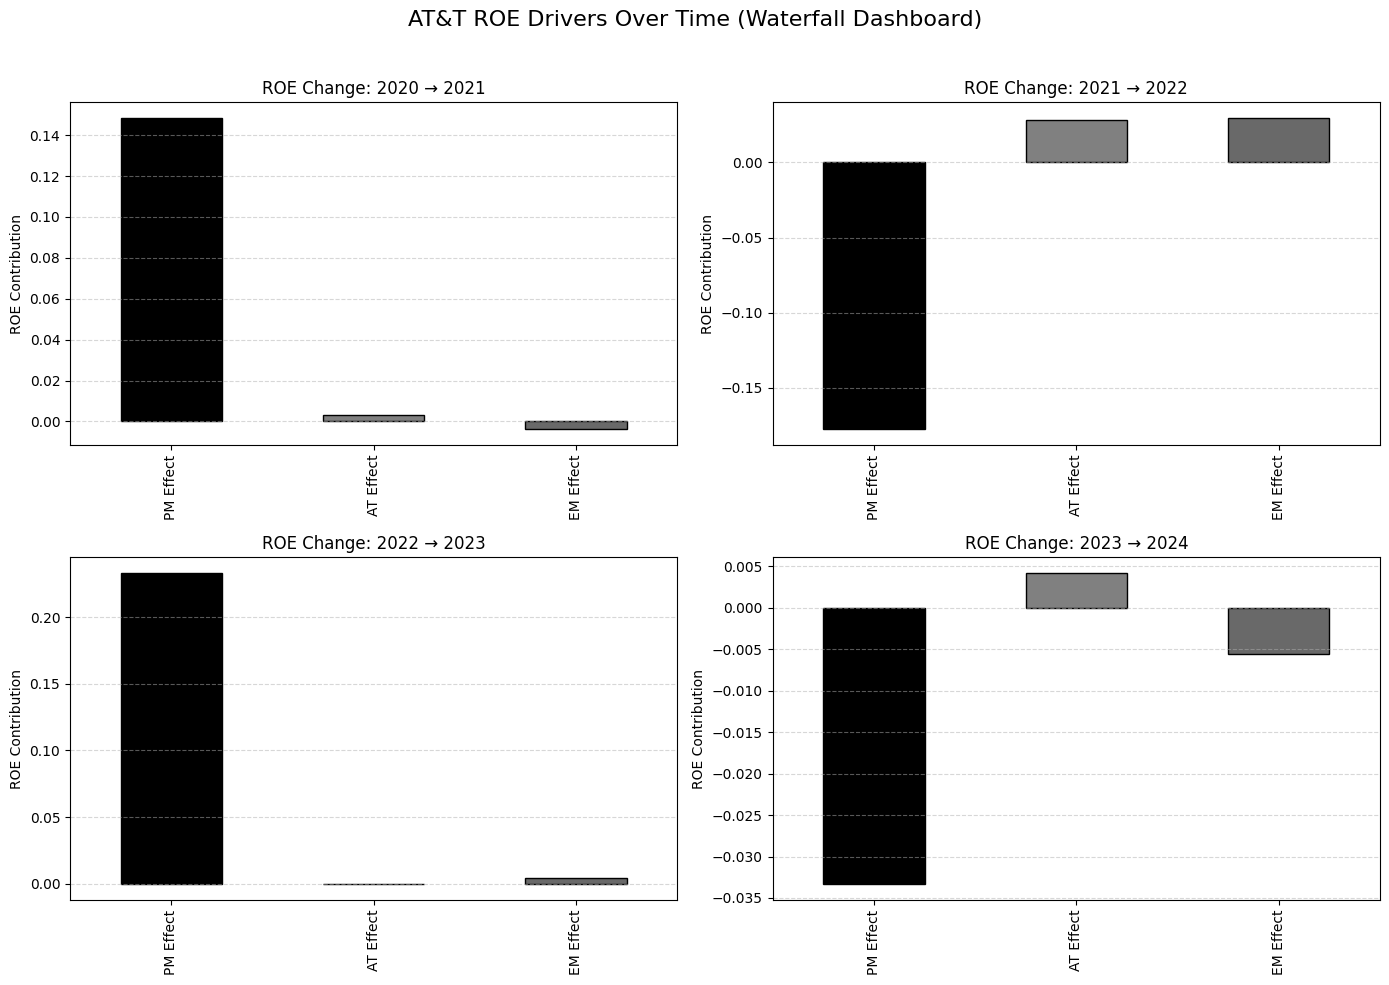

In [ ]:


# Function to compute PM, AT, EM effects
def roe_waterfall(prev_year, curr_year, dup):
    pm_prev, at_prev, em_prev = dup.loc["ProfitMargin", prev_year], dup.loc["AssetTurnover", prev_year], dup.loc["EquityMultiplier", prev_year]
    pm_curr, at_curr, em_curr = dup.loc["ProfitMargin", curr_year], dup.loc["AssetTurnover", curr_year], dup.loc["EquityMultiplier", curr_year]

    effect_pm = (pm_curr - pm_prev) * at_prev * em_prev
    effect_at = pm_prev * (at_curr - at_prev) * em_prev
    effect_em = pm_prev * at_prev * (em_curr - em_prev)

    return pd.Series({"PM Effect": effect_pm, "AT Effect": effect_at, "EM Effect": effect_em})


# Build dashboard
year_pairs = [(2020,2021),(2021,2022),(2022,2023),(2023,2024)]

fig, axes = plt.subplots(2, 2, figsize=(14,10))
fig.suptitle("AT&T ROE Drivers Over Time (Waterfall Dashboard)", fontsize=16)

for ax, (y1,y2) in zip(axes.flatten(), year_pairs):
    wf = roe_waterfall(y1, y2, att_dup)

    wf.plot(kind="bar",
            ax=ax,
            color=["black", "gray", "dimgray"],   # AT&T color scheme
            edgecolor="black")

    ax.set_title(f"ROE Change: {y1} → {y2}", fontsize=12)
    ax.set_ylabel("ROE Contribution")
    ax.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
